In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/accepted_2007_to_2018Q4.csv' ,
    parse_dates=['issue_d'], infer_datetime_format=True)
data = data[(data.issue_d >= '2018-01-01 00:00:00') & (data.issue_d < '2019-01-01 00:00:00')]
data = data.reset_index(drop=True)
data.head()

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3050: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,130954621,NaN,5000.0,5000.0,5000.0,36 months,20.39,186.82,D,D4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,130964697,NaN,15000.0,15000.0,15000.0,36 months,9.92,483.45,B,B2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,130955326,NaN,11200.0,11200.0,11200.0,60 months,30.79,367.82,G,G1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,130504052,NaN,25000.0,25000.0,25000.0,60 months,21.85,688.35,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,130956066,NaN,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.shape

(495242, 151)

## Defining the target and putting it on the side:

In [4]:
target = data['loan_status']
data = data.drop('loan_status', axis=1)

In [5]:
target.unique()
target.value_counts()

Current               427181
Fully Paid             47444
Charged Off             8867
Late (31-120 days)      7221
In Grace Period         2919
Late (16-30 days)       1603
Default                    7
Name: loan_status, dtype: int64

In [6]:
newTarget = target.isin(['Current','Fully Paid'])
newTarget.value_counts()

True     474625
False     20617
Name: loan_status, dtype: int64

## Label Encoding

In [7]:
datacopy = data.copy()
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

MCLE = defaultdict(LabelEncoder) # Multi Column Label Encoder
nanDict = defaultdict() # Storing NaN encoding to restore Nans

In [8]:
(data.dtypes=='object').sum() #Number of columns to be label encoded

36

In [9]:
for col in  data.columns:
    foo = col
    if(data.dtypes[col]=='object'):
        MCLE[col].fit(data[col].astype(str))
        data[col]=MCLE[col].transform(data[col].astype(str))
        try:
            nanDict[col]=MCLE[col].transform(['nan'])[0] # If Nan was encoded to a number
        except:
            ()
        else:
            data[col][data[col]==nanDict[col]]=np.nan # Restore the nan value
            ()

<ipython-input-9-8b63eff94fe8>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][data[col]==nanDict[col]]=np.nan # Restore the nan value


In [10]:
data.dtypes.unique() #Sanity check

array([dtype('int64'), dtype('float64'), dtype('<M8[ns]')], dtype=object)

# Feature Selection

## Filtering features with too many missing values:

In [11]:
miss = data.isnull().sum().sort_values(ascending = False)/data.shape[0]
miss #Fraction of missing data in said feature

desc                                          1.000000
member_id                                     1.000000
orig_projected_additional_accrued_interest    0.999352
hardship_end_date                             0.999257
deferral_term                                 0.999257
                                                ...   
acc_open_past_24mths                          0.000000
chargeoff_within_12_mths                      0.000000
delinq_amnt                                   0.000000
mo_sin_old_rev_tl_op                          0.000000
id                                            0.000000
Length: 150, dtype: float64

In [12]:
missThreshold = 0.9
tooManyMiss = miss[miss > missThreshold].index 
print(tooManyMiss,len(tooManyMiss)) #Features to be removed and total number of them

Index(['desc', 'member_id', 'orig_projected_additional_accrued_interest',
       'hardship_end_date', 'deferral_term', 'payment_plan_start_date',
       'hardship_length', 'hardship_dpd', 'hardship_loan_status',
       'hardship_last_payment_amount', 'hardship_payoff_balance_amount',
       'hardship_amount', 'hardship_status', 'hardship_reason',
       'hardship_type', 'hardship_start_date', 'settlement_percentage',
       'settlement_term', 'debt_settlement_flag_date', 'settlement_status',
       'settlement_date', 'settlement_amount',
       'sec_app_mths_since_last_major_derog'],
      dtype='object') 23


In [13]:
data = data.drop( tooManyMiss, axis=1) #Pruning features with too many missing values

## Removing unexplicative features

In [14]:
nUnique = data.nunique().sort_values()
nUnique #Number of unique values per features

policy_code                  1
num_tl_120dpd_2m             1
debt_settlement_flag         2
application_type             2
acc_now_delinq               2
                         ...  
total_pymnt_inv         236121
tot_cur_bal             254794
tot_hi_cred_lim         266282
url                     495242
id                      495242
Length: 127, dtype: int64

In [15]:
data = data.drop(['id','url'],axis=1) #made up, not explicative

In [16]:
data = data.drop(nUnique[nUnique==1].index, axis=1) #pruning features with only one value

In [17]:
data.shape[1] 

123

## Exploring values

In [18]:
for column in data.columns:
    print(column, data[column].unique()[:10])

loan_amnt [ 5000. 15000. 11200. 25000.  3000. 17000. 20000. 19200.  6500. 10000.]
funded_amnt [ 5000. 15000. 11200. 25000.  3000. 17000. 20000. 19200.  6500. 10000.]
funded_amnt_inv [ 5000. 15000. 11200. 25000.  3000. 17000. 20000. 19200.  6500. 10000.]
term [0 1]
int_rate [20.39  9.92 30.79 21.85  7.34 10.41 17.47  6.07 12.61 13.58]
installment [186.82 483.45 367.82 688.35  93.1  454.1  649.21 482.04 197.95 225.54]
grade [3 1 6 0 2 4 5]
sub_grade [18  6 30 19  3  7 15  1 10 11]
emp_title [ 44814.  50642.  19883.   6434.  91055.  51672.     nan 114801. 119633.
 104762.]
emp_length [ 8.  2. 10.  1.  9. nan  5.  4.  0.  7.]
home_ownership [3 2 1 0]
annual_inc [ 50000. 196000.  44000.  65000.  52000.  19000.  36500.  80000.  46000.
  59940.]
verification_status [2 1 0]
issue_d ['2018-03-01T00:00:00.000000000' '2018-02-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000' '2018-09-01T00:00:00.000000000'
 '2018-08-01T00:00:00.000000000' '2018-07-01T00:00:00.000000000'
 '2018-12-01T00:00:0

## Correlation Filter

In [19]:
from itertools import combinations

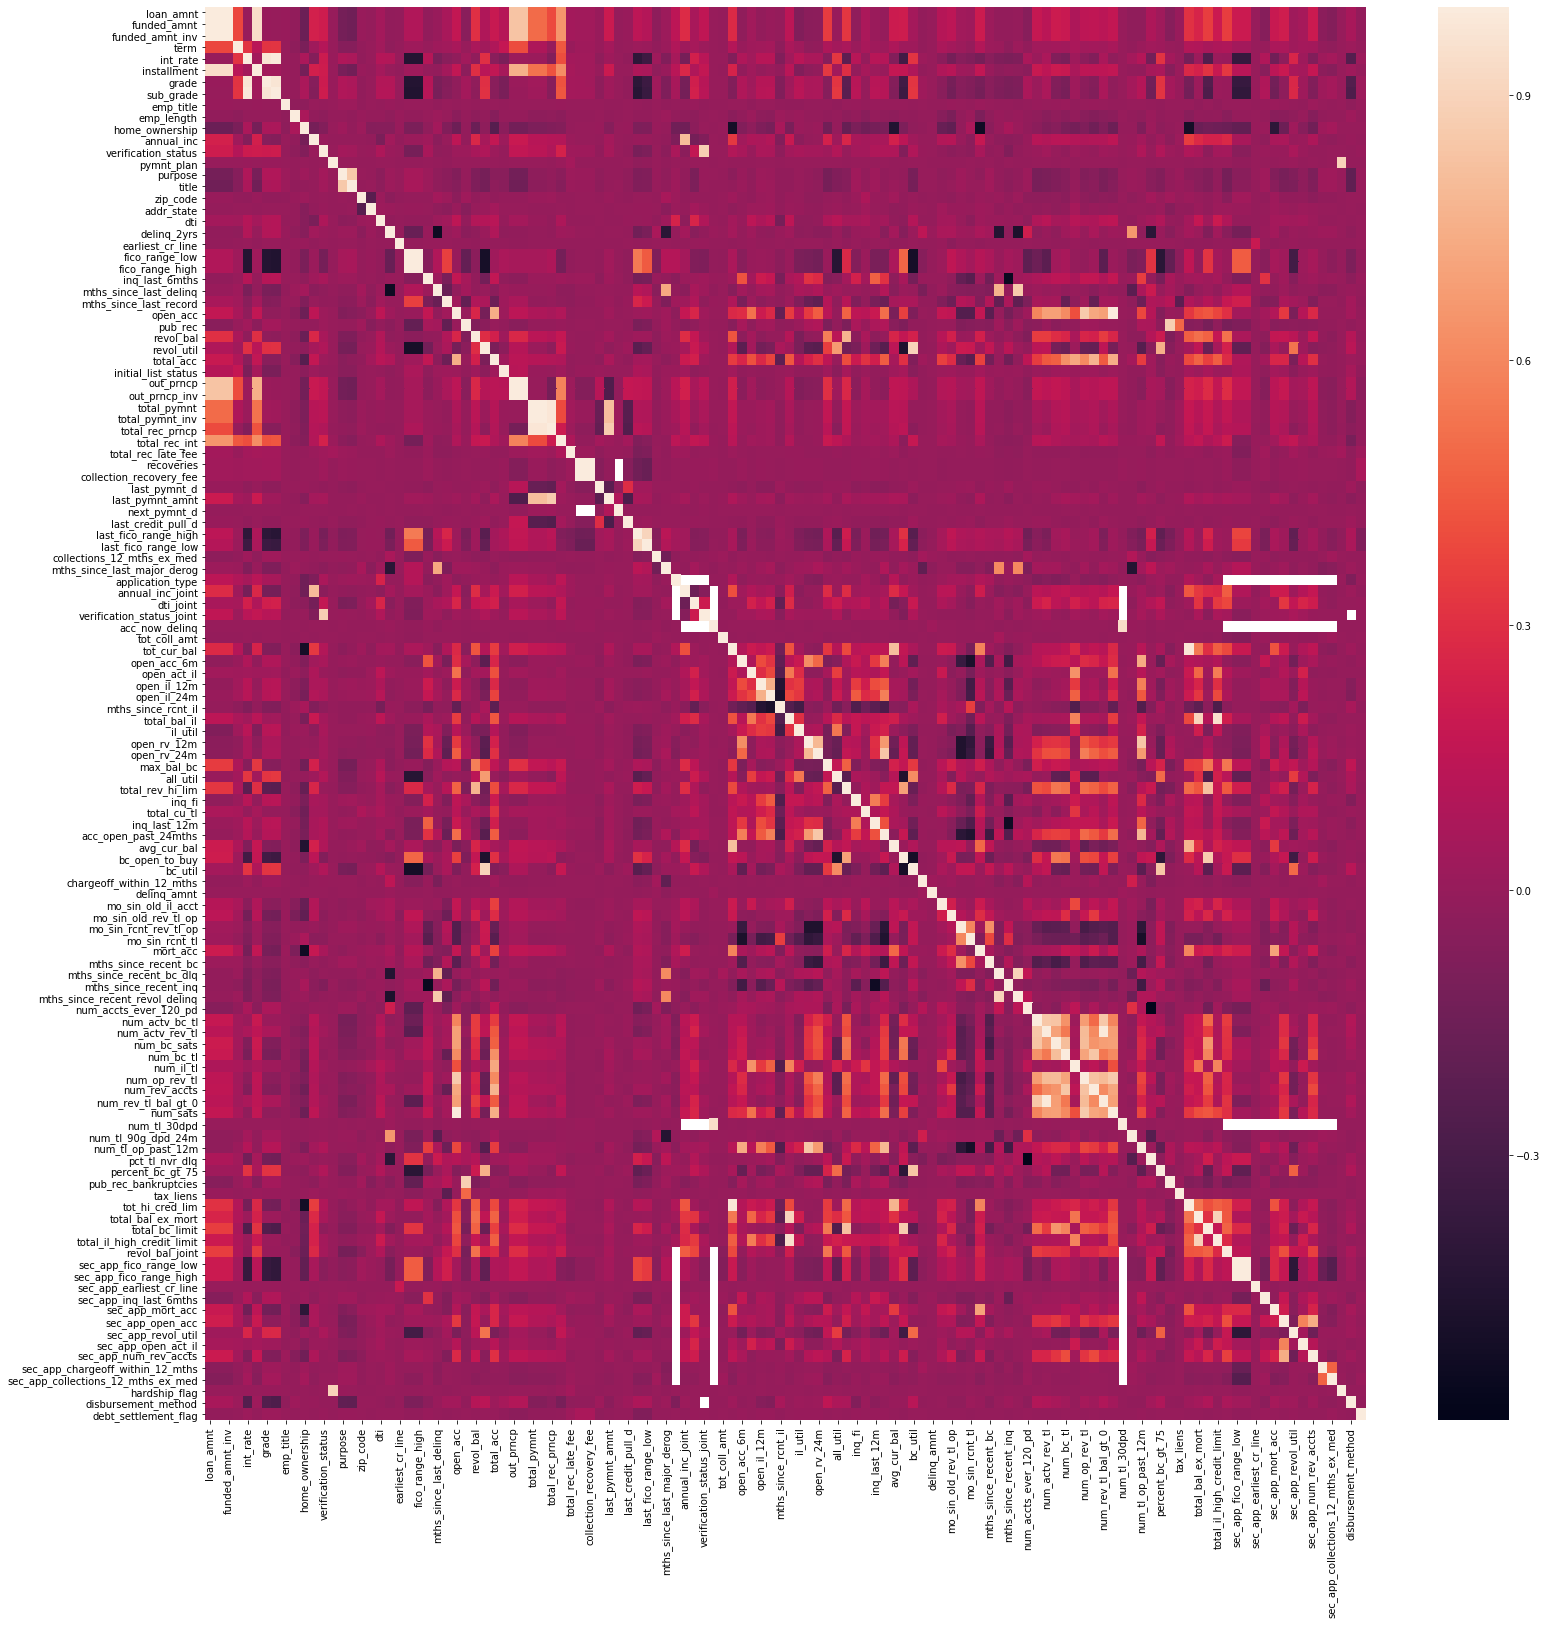

In [20]:
import seaborn as sns
corrMat = data.corr()
plt.figure(figsize = (26,26))
sns.heatmap(corrMat)

In [21]:
highCorrThreshold = 0.9
highCorrPairs = []
for x in combinations(range(corrMat.shape[0]),2):
    if np.abs(corrMat.iloc[x]>highCorrThreshold):
        highCorrPairs += [(corrMat.index[x[0]],corrMat.index[x[1]])]
print(highCorrPairs,len(highCorrPairs))

[('loan_amnt', 'funded_amnt'), ('loan_amnt', 'funded_amnt_inv'), ('loan_amnt', 'installment'), ('funded_amnt', 'funded_amnt_inv'), ('funded_amnt', 'installment'), ('funded_amnt_inv', 'installment'), ('int_rate', 'grade'), ('int_rate', 'sub_grade'), ('grade', 'sub_grade'), ('fico_range_low', 'fico_range_high'), ('open_acc', 'num_sats'), ('out_prncp', 'out_prncp_inv'), ('total_pymnt', 'total_pymnt_inv'), ('total_pymnt', 'total_rec_prncp'), ('total_pymnt_inv', 'total_rec_prncp'), ('recoveries', 'collection_recovery_fee'), ('last_fico_range_high', 'last_fico_range_low'), ('acc_now_delinq', 'num_tl_30dpd'), ('tot_cur_bal', 'tot_hi_cred_lim'), ('total_bal_il', 'total_bal_ex_mort'), ('total_bal_il', 'total_il_high_credit_limit'), ('num_actv_rev_tl', 'num_rev_tl_bal_gt_0'), ('sec_app_fico_range_low', 'sec_app_fico_range_high')] 23


In [22]:
highCorrDrop = [x[1] for x in highCorrPairs]
highCorrDrop = np.unique(highCorrDrop)
data = data.drop(highCorrDrop, axis=1)

In [23]:
data.shape[1]

105

## Filling na, removing timestamp column

In [24]:
data= data.fillna(data.mean())

In [25]:
data.dtypes[data.dtypes=='<M8[ns]']

issue_d    datetime64[ns]
dtype: object

In [26]:
dateTime = data['issue_d']
data = data.drop('issue_d', axis = 1)

## Target Classification F score / Chi squared Analysis

In [27]:
# For Correlation (this is classification)
# targetChi = pd.Series()
# for col in data.columns:
#     try:
#         targetCorr[col]= newTarget.values,corr(data[col])
#     except:
#         ()
        
# ### For testing log transformation
# # for col in data.columns:
# #     try:
# #         targetCorr['log'+col]= newTarget.corr(data[col].apply(np.log))
# #     except:
# #         ()
# # targetCorr = targetCorr.dropna()

# targetCorr.abs().sort_values()

In [28]:
from sklearn.feature_selection import chi2,f_classif

In [29]:
feature_chi2 = f_classif(data,newTarget)
chi2sort = np.argsort(feature_chi2[0])
for x in range(len(chi2sort)):
    print(data.columns[x], feature_chi2[0][chi2sort[x]],feature_chi2[1][chi2sort[x]])

loan_amnt 0.011522455116502942 0.9145171544608226
term 0.520438010375625 0.47065523992665315
int_rate 0.608715140588152 0.4352723661589526
emp_title 1.2080836428547586 0.2717125180261335
emp_length 2.043535233142231 0.15285467760730995
home_ownership 2.1933250316544006 0.1386104455186909
annual_inc 2.7174482952093726 0.09925721000219782
verification_status 3.1147537960386082 0.07758681966783507
pymnt_plan 4.446283880453487 0.03497778169551177
purpose 6.407047419001871 0.01136713426777701
title 8.693282127698089 0.003193998950939267
zip_code 10.494939398241055 0.0011970983130562415
addr_state 10.495219980645075 0.001196916544297819
dti 11.922737249664507 0.0005545757147440027
delinq_2yrs 12.241107340921745 0.0004675217756949997
earliest_cr_line 14.61365110205285 0.00013197134246844899
fico_range_low 15.79489931552344 7.060255344757791e-05
inq_last_6mths 19.338848629089068 1.0947935238228182e-05
mths_since_last_delinq 20.555064686546878 5.7953833180826665e-06
mths_since_last_record 20.81

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, newTarget)

In [31]:
def selectKBest(X,k,sortlist):
    return X.drop(X.columns[sortlist[:-k]],axis=1)
k = 20
X_y_train = selectKBest(X_train,k,chi2sort)
X_y_test = selectKBest(X_test,k,chi2sort)

In [32]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score


XGBC = xgb.XGBClassifier(max_depth=5,n_estimators=10,scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1])
XGBC.fit(X_y_train,y_train)
y_pre_xgb= XGBC.predict(X_y_test)

/usr/lib/python3.8/site-packages/sklearn/base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


## Metrics

Accuracy (test): 0.921
Precision (test): 0.998
Recall (test): 0.919)
ROC AUC score (test): 0.939


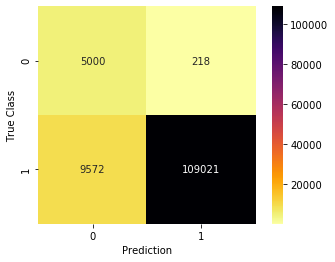

In [33]:
acc_test = accuracy_score(y_test, y_pre_xgb)
prec_test = precision_score(y_test, y_pre_xgb)
rec_test = recall_score(y_test, y_pre_xgb)
roc_auc_test =roc_auc_score(y_test,y_pre_xgb)

print(f'''Accuracy (test): {acc_test:.3f}
Precision (test): {prec_test:.3f}
Recall (test): {rec_test:.3f}
ROC AUC score (test): {roc_auc_test:.3f}''')

cm = confusion_matrix(y_test, y_pre_xgb)
ax = sns.heatmap(cm, cmap='inferno_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Prediction')
ax.set_ylabel('True Class');


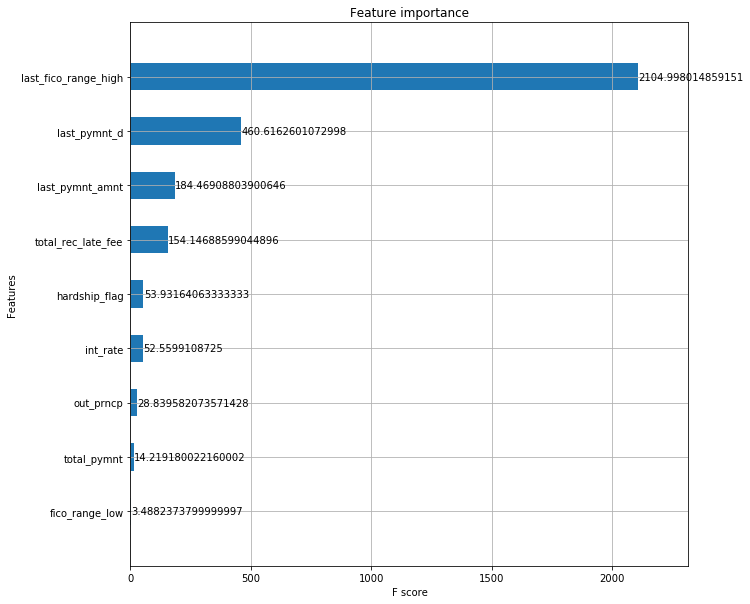

In [87]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(XGBC, height=0.5, ax=ax, importance_type='gain')
plt.show()

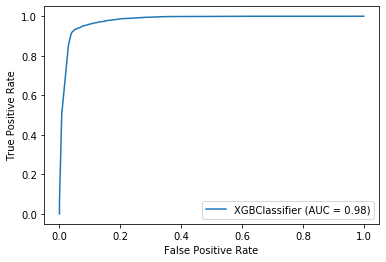

In [35]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(XGBC, X_y_test, y_test)


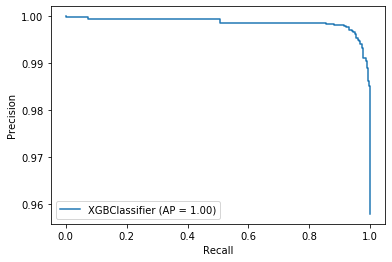

In [36]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(XGBC,X_y_test,y_test)

In [37]:
important_features = X_y_test.columns[np.argsort(XGBC.feature_importances_[np.abs(XGBC.feature_importances_)>0])][::-1]

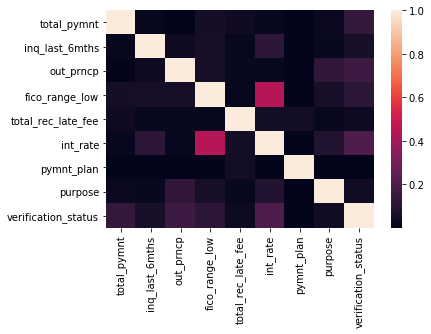

In [88]:
sns.heatmap(corrMat.loc[important_features,important_features].abs())